# Introduction

We have learned a lot about CNNs. And in this notebook we will talk about a detail that is been happening behind the scenes when we build and train neural networks in PyTorch, and that's weights initialization.

Weight initialization happens right when a model is created, before it sees any training data, and it generally only happens one time when a model is first created. Weight initialization is all about how we can instantiate a model, like a CNN, so that its weights, the model parameters, are starting off with the best initial values for a given task. 

We recommend to thing of it this way, any neuron in a model has some weights and biases that operate on some input values and transform them into desired outputs. It is how we might transform an input image into some class scores. A model is trying to learn the best weights to map inputs to outputs and, say, most accurately classify some given images. 

When we did transfer learning, we basically initialized a network with the best pre-trained weights, weights that we know are good values for image classification. But for a non-pretrained model, how should we initialize the weights? We could start for example by saying all the weights are going to be zero, and we will train them until they are shifted up or down, or we could start out with large weight values, or even some random values, and see what happens.

These are the questions that we will be exploring in this notebook.We will demostrate the effect of different weight initialization strategiess, discuss how we might decide on initial weights and what indicates good initial behavior during training. 

The plan: we want to define one kind of model, a simple MLP,  and we will initialize the weights of this model with different values, and compare how the training losses decrease over the first epoch or two of training. Same models, different initial weights. 

Some initialization strategies may offer some really big improvements to how the loss decreases, and others may offer small improvements. Big or small, we can learn from all of these differences. We will be using the Fashion-MNIST dataset. A simple ataset like this one is often used to test network performance, because the dataset is simple to use and its training behavior is fairly well understood. We know for example that we should be able to get the training loss to reliably decrease. 

We will be using a `helpers.py` file, the purpose of this notebook is not to train the model until it performs well on the classification task, but rather we just want to see how well the models train given different initial weights. In that `helpers.py` file we have a main helper function `get_loss_acc`, which takes in a model, and the training and validation model. We defined the length fo time to train a model choosing 2 epochs, and we also defined a loss and optimization functions there, using cross-entropy  and an Adam optimizer, but feel free to change this to Stochastic gradient descent and see how it performs. Then in the function, we are actually going to train the model for 2 epochs, and record the training loss as we go. This loss is going to be recorded in a list called `loss_batch`. After a model has trained for 2 epochs, we then see how it performs on our validation data set. We compare the predicted and the correct class, and see which ones match. Finally, we return the list of training loss over time and that validation accuracy. Another helper function will compare its weights, which takes in a list of models. For each model in our list, it will record the training loss and the validation accuracy over 2 epochs, and compare at least two models. 

# Weight Initialization
In this lesson, you'll learn how to find good initial weights for a neural network. Weight initialization happens once, when a model is created and before it trains. Having good initial weights can place the neural network close to the optimal solution. This allows the neural network to come to the best solution quicker. 

<img src="assets/neuron_weights.png" width=40%/>


## Initial Weights and Observing Training Loss

To see how different weights perform, we'll test on the same dataset and neural network. That way, we know that any changes in model behavior are due to the weights and not any changing data or model structure. 
> We'll instantiate at least two of the same models, with _different_ initial weights and see how the training loss decreases over time, such as in the example below. 

<img src="assets/loss_comparison_ex.png" width=60%/>

Sometimes the differences in training loss, over time, will be large and other times, certain weights offer only small improvements.

### Dataset and Model

We'll train an MLP to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist) to demonstrate the effect of different initial weights. As a reminder, the FashionMNIST dataset contains images of clothing types; `classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']`. The images are normalized so that their pixel values are in a range [0.0 - 1.0).  Run the cell below to download and load the dataset.

---
#### EXERCISE

[Link to normalized distribution, exercise code](#normalex)

---

### Import Libraries and Load [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100.0%

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


111.0%

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


100.0%

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


159.1%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


### Visualize Some Training Data

/Users/mb78200/opt/anaconda3/envs/my_p3_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


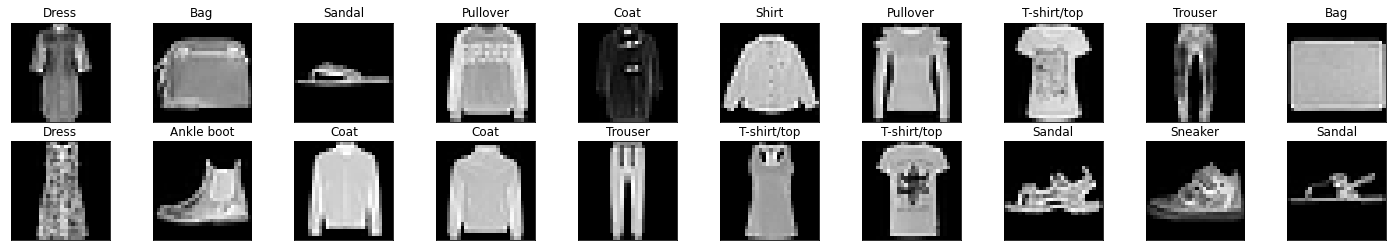

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

# Constant weights

So, we have the general layout of our MLP, and we are training this model to classify 10 types of clothes in the fashion MNIST dataset. We really just want to look at how a model trains when it is given different initial weights. 

## Define the Model Architecture

We've defined the MLP that we'll use for classifying the dataset.

### Neural Network
<img style="float: left" src="notebook_ims/neural_net.png" width=50%/>


* A 3 layer MLP with hidden dimensions of 256 and 128. 

* This MLP accepts a flattened image (784-value long vector) as input and produces 10 class scores as output.
---
We'll test the effect of different initial weights on this 3 layer neural network with ReLU activations and an Adam optimizer.  

The lessons you learn apply to other neural networks, including different activations and optimizers.

---
## Initialize Weights
Let's start looking at some initial weights.
### All Zeros or Ones
If you follow the principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor), you might think setting all the weights to 0 or 1 would be the best solution.  This is not the case.

With every weight the same, all the neurons at each layer are producing the same output.  This makes it hard to decide which weights to adjust.

Let's compare the loss with all ones and all zero weights by defining two models with those constant weights.

Below, we are using PyTorch's [nn.init](https://pytorch.org/docs/stable/nn.html#torch-nn-init) to initialize each Linear layer with a constant weight. The init library provides a number of weight initialization functions that give you the ability to initialize the weights of each layer according to layer type.

In the case below, we look at every layer/module in our model. If it is a Linear layer (as all three layers are for this MLP), then we initialize those layer weights to be a `constant_weight` with bias=0 using the following code:
>```
if isinstance(m, nn.Linear):
    nn.init.constant_(m.weight, constant_weight)
    nn.init.constant_(m.bias, 0)
```

The `constant_weight` is a value that you can pass in when you instantiate the model.


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self, hidden_1=256, hidden_2=128, constant_weight=None):
        super(Net, self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (hidden_2 -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
        # initialize the weights to a specified, constant value
        if(constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)
    
            
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x


In the if bloc, let's say we have passed in a constant way of zero, then we enter this if statement, the for statement looks at every module or layer in our model. Then it says, let's check the layer type. For every linear layer, we are going to set the parameter weights to a constant value using `nn.init.constant`.  This takes in the weights we want to set from our module and a constant weight value, which we passed in. We do the exact same thing for our module bias, only we are setting the bias to zero. 

So, all we have to do to set the weights is to specify how we want to initialize each linear layer and then use the `nn.init`library to help set those values. This library includes a lot of common initialization schemes that we will go over. 

Next, we actually need to instantiate two different kinds of models with two different constant weights. So, let's create a model with a constant weight `0` and another one with constant weight `1`

### Compare Model Behavior

Below, we are using `helpers.compare_init_weights` to compare the training and validation loss for the two models we defined above, `model_0` and `model_1`.  This function takes in a list of models (each with different initial weights), the name of the plot to produce, and the training and validation dataset loaders. For each given model, it will plot the training loss for the first 100 batches and print out the validation accuracy after 2 training epochs. *Note: if you've used a small batch_size, you may want to increase the number of epochs here to better compare how models behave after seeing a few hundred images.* 

We plot the loss over the first 100 batches to better judge which model weights performed better at the start of training. **I recommend that you take a look at the code in `helpers.py` to look at the details behind how the models are trained, validated, and compared.**

Run the cell below to see the difference between weights of all zeros against all ones.

In [4]:
# initialize two NN's with 0 and 1 constant weights
model_0 = Net(constant_weight=0)
model_1 = Net(constant_weight=1)

We create the moduls then using the `helpers.py`functions, we are actually going to compare these two models and how they perform over two epics. 

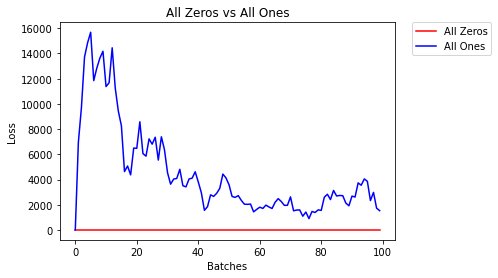

After 2 Epochs:
Validation Accuracy
    9.550% -- All Zeros
   10.008% -- All Ones
Training Loss
    2.302  -- All Zeros
  378.607  -- All Ones


In [5]:
import helpers

# put them in list form to compare
model_list = [(model_0, 'All Zeros'),
              (model_1, 'All Ones')]


# plot the loss over the first 100 batches
helpers.compare_init_weights(model_list, 
                             'All Zeros vs All Ones', 
                             train_loader,
                             valid_loader)

As we can see, the model that starts out with all ones as weights start out with an extremely hig initial loss. Usually for something with cross entropy loss, we are expecting a value in the single digits. We also see that when a model is initialized with all zeros, its line just sort of remains flat over time and doesn't change. The loss never really decreases. So what exactly is happening here?

Let's talk about our model that starts out with a constant weight of zero. In this case, every single hodden node is going to respond to the inputs it sees in the exact same way. It will multiply all of these inputs by a constant weight of zero and then add all of them up. This behavior repeats in the second layer where all the weights are zero and again in the third producing a series of class scores. Now, in any training process, these class scores will not be very accurate at first, but that's okay as long as we can learn from any mistakes. But in the case of all zero initial weights, when we go to calculate the cross entropy loss and use backpropagation to identify sources of error, it all of the sudden becomes very hard to see which weights, which nodes are responsible for making any errors. Because the weights were all zero in the hidden layers, all the gradients that tell us how changes with respect to each weight are also all the same and can't tell us anything. We have a really hard time finding out whit weights should be updated and by how much. 

Something similar happens if the weights are all initialized as ones. When the weights are all ones,  then again we are going to have our input pixel values multiplied by one and summed in a hidden node. Again, the hidden layer calculations are going to be the same as inputs moved forward through the MLP layers. When we try to identify sources of error, we can't really. So after two epochs, we are also recording the validation accuracy.

As we can see the accuracy is close to guessing for both zeros and ones, around 10%.

Those constant weights are basically just performing really poorly, but it is still helpful to see this behavior through a critial lens. Again, because our weights are all the same, that means the activations of all our units in the hidden layers are also all the same. So, the backpropagation algorithm struggles to minimize the loss. Using constant initial weights essentially sets up backpropagation to fail because it is not designed to deal with consistency. Backpropagation is designed to look at how different weight values affect the training loss.

The neural network is having a hard time determining which weights need to be changed, since the neurons have the same output for each layer.  To avoid neurons with the same output, let's use unique weights.  We can also randomly select these weights to avoid being stuck in a local minimum for each run.

A good solution for getting these random weights is to sample from a uniform distribution.